In [1]:
import pandas as pd
import numpy as np

In [2]:
#读取训练数据集
mblog=pd.read_csv('clean_mblog.csv',encoding='utf_8_sig')
mblog.head()

,mid,chinese_text,like_count,comments_count,reposts_count,created_date,user_id,isLongText,attitude
0,4.420000e+15,中秋福利哈，老爷子支持的转账已就位哈哈关注我的真爱转这条抽一个宝贝送新款5g华为mate30...,919,1003,2817,9月13日,1749268063,0,1.0
1,4.420000e+15,远行随拍，博友假日快乐别说追最新的Mate30系列，iPhone11系列拍照水准就连P30系...,73,87,6,9月15日,1219795431,0,1.0
2,4.420000e+15,疑似华为mate30 pro真机上手打游戏…小刘海，瀑布屏。真真假假，假假真真。,32,34,0,9月15日,1840918185,0,0.0
3,4.420000e+15,疑似华为Mate30 保护壳曝光，或采用5倍光变的潜望式镜头。,9,8,2,9月15日,2400814017,0,1.0
4,4.420000e+15,这个是华为Mate30 PRO吗？想翻过来看正面是不是瀑布屏。,2,1,0,9月15日,3788429711,0,0.0


In [3]:
import jieba.analyse
def get_keywords(raw):
    if raw['isLongText'] == 1:
        # 当text为长文本时，提取50个关键词
        keywords = jieba.analyse.extract_tags(raw['chinese_text'],topK=50)
        keywords = '|'.join(keywords)
        return keywords
    else:
        # 当text为非长文本时，默认提取20个关键词
        keywords = jieba.analyse.extract_tags(raw['chinese_text'])
        keywords = '|'.join(keywords)
        return keywords
    

In [4]:
#生成keyword数据
mblog['keywords'] = mblog.apply(get_keywords,axis=1)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\QIU\AppData\Local\Temp\jieba.cache
Loading model cost 1.554 seconds.
Prefix dict has been built succesfully.


In [5]:
#导入逻辑回归模型
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=2000,analyzer='word',tokenizer=lambda s:s.split('|'))

In [6]:
#生成词袋向量数据
blog_bow = vectorizer.fit_transform(mblog['keywords'])

In [7]:
#选定训练样本数据
y = mblog[mblog['attitude'].notnull()]['attitude']
X=blog_bow[:len(y),:]

In [8]:
#训练模型并查看训练准确率
lr_model = LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial').fit(X,y)
lr_model.score(X,y)

0.99

In [10]:
# 对其他微博进行预测并查看结果
print(mblog.chinese_text.iloc[8])
print(lr_model.predict(blog_bow[8,:]))

华为Mate30保护壳曝光，感觉好丑啊 
[0.]


在训练样本中该条微博被人工标注为-1：消极  
但模型在预测时将其标注为0：中性

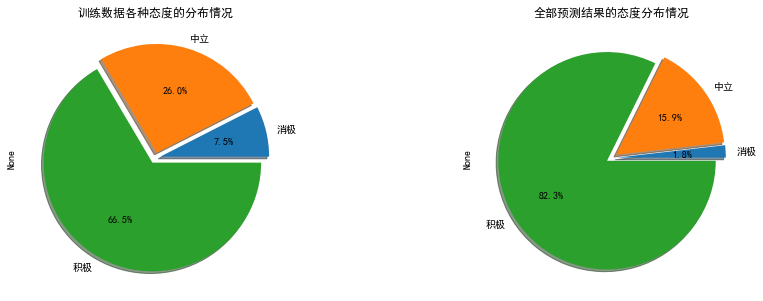

In [12]:
#查看训练数据各种态度的分布情况
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
%matplotlib inline
predict_attitude = pd.DataFrame(lr_model.predict(blog_bow[:,:]),columns=['predict'])
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
labels = ['消极','中立','积极']
plt.title('训练数据各种态度的分布情况')
mblog.groupby('attitude').size().plot.pie(labels=labels,autopct='%1.1f%%',explode=(0.05,0.05,0.05),shadow=True)
plt.subplot(1,2,2)
labels = ['消极','中立','积极']
plt.title('全部预测结果的态度分布情况')
predict_attitude.groupby('predict').size().plot.pie(labels=labels,autopct='%1.1f%%',explode=(0.05,0.05,0.05),shadow=True)

模型分析：  
根据预测的多个微博数据结果，模型把大部分微博都预测为了积极的，分析数据的特点，推测可能是由于数据的分布极不均匀导致的  
查看各种态度的分布情况可验证这一推测。